In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector
from scipy.optimize import minimize



In [2]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"
2

2

In [11]:
t1=time.time()
G_osm=rebuild_osm_graph(cursor,osm_nodes_table_name=osm_nodes_table_name,osm_edges_table_name=osm_edges_table_name)
t2=time.time()
print(t2-t1)

0.418642520904541


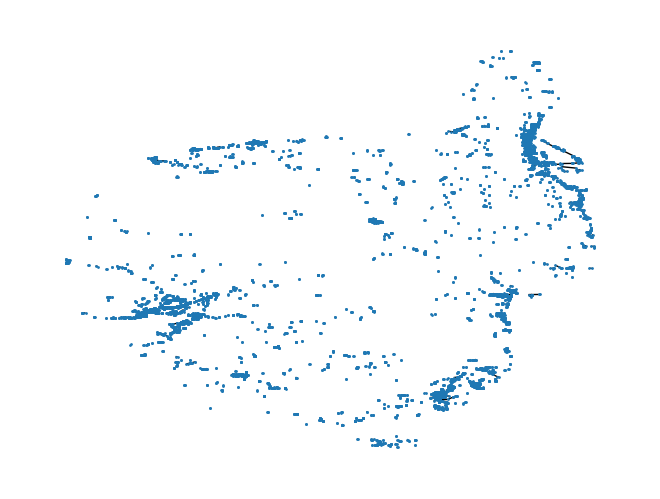

In [12]:
pos={node:(datum['x'],datum['y']) for node,datum in G_osm.nodes(data=True)}
nx.draw(G_osm,pos=pos,node_size=1)

In [13]:
t1=time.time()
complete_osm_graph(G_osm,cursor,osm_edges_table_name=osm_edges_table_name,intersections_table_name=intersections_table_name)
t2=time.time()
print(t2-t1)

2.595018148422241


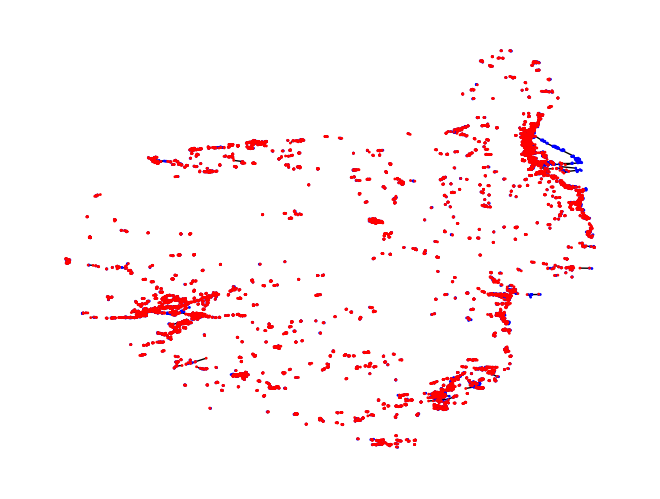

In [15]:
node_color=['r' if isinstance(node,tuple)  else 'b' for node in G_osm.nodes()]
pos={node:(datum['x'],datum['y']) for node,datum in G_osm.nodes(data=True)}
nx.draw(G_osm,pos=pos,node_size=1,node_color=node_color)

In [16]:
t1=time.time()
CC=sorted(list(nx.connected_components(nx.Graph(G_osm))),key=len)
t2=time.time()
print(t2-t1)

0.19065451622009277


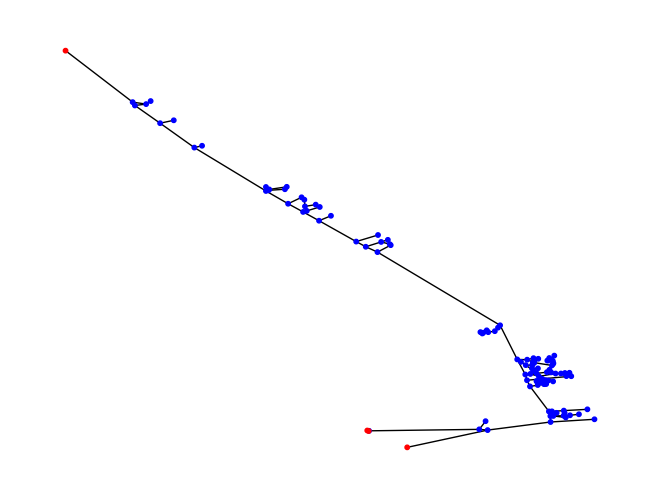

In [19]:
cc=CC[-2]
sub_G_osm=nx.subgraph(G_osm,cc).copy()

pos={node:(datum['x'],datum['y']) for node,datum in sub_G_osm.nodes(data=True)}
node_color=['r' if isinstance(node,tuple)  else 'b' for node in sub_G_osm.nodes()]
nx.draw(sub_G_osm,pos=pos,node_color=node_color,node_size=10)

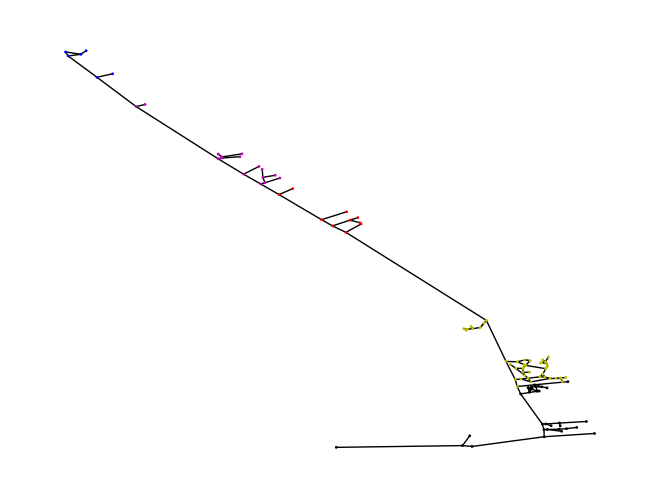

In [20]:
colors=['b','m','r','y','k']
nodes,estimated_elevations=estimate_elevations_from_laplacian(sub_G_osm)
sub_G_osm=nx.subgraph(sub_G_osm,nodes)
integer_elevations=list(np.round(estimated_elevations-np.min(estimated_elevations)).astype('int'))
node_color=[colors[integer_elevation%len(colors)] for integer_elevation in integer_elevations]
nx.draw(sub_G_osm,pos=pos,node_color=node_color,node_size=1)

In [22]:
UPDATE_ELEVATION=True
if UPDATE_ELEVATION:
    t1=time.time()
    add_nodes_elevations_to_database(G_osm,cursor,osm_nodes_table_name=osm_nodes_table_name)

    t2=time.time()
    print(t2-t1)





only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
Desired error not necessarily achieved due to precision loss.
only one available elevation
only one available elevation
only one available elevation
Desired error not necessarily achieved due to precision loss.
only one available elevation
only one available elevation
only one available elevation
Desired error not necessarily achieved due to precision loss.
only one available elev